In this document we work on draft 1 to get rid of dropout, make data augmentation less noisy and increase learning rate.


In [1]:
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt
import numpy as np

**Data Augmentation**

We decrease the noisiness of the data augmentation to favour faster learning with less training. We do this by decreasing the parameters associated with rotation, cropping and colourjitter.

In [2]:
batch_size = 10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),   #flips image with 50% probability
    transforms.RandomRotation(10),       #rotates image either +10 or -10 degrees
    transforms.RandomCrop(32, padding=1),#now only pads 1 pixel
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # random color changes
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalising as before
])
transform_test = transforms.Compose([  #we keep the old transformations on the test set
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Downloading and loading augmented Dataset**

In [3]:
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #we apply the new augmented transformation to the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) #and apply a non-augmenting transform to the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
print(testset.transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


The above downloads and loads the CIFAR-10 dataset, and augments the data in the training set. It doesn't augment the data in the testing set, since we still want to test the performance on the regular data.

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
traindataiter = iter(trainloader)
images, labels = next(traindataiter)

**Visualising images**

We check that the images have been altered correctly:

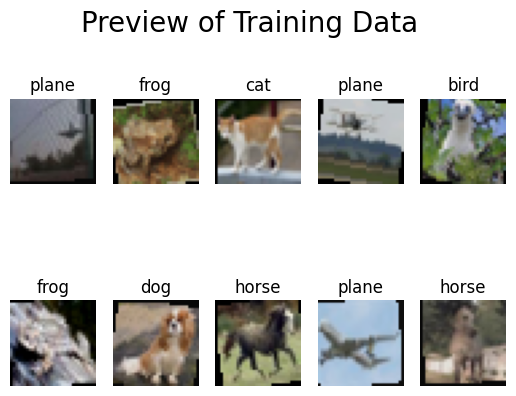

In [6]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

Now the photos are still irregular but more recognisable. The variation should still increase robustness.

Let's also check that the testing set has been altered as we intended.

In [7]:
testdataiter = iter(testloader)
images, labels = next(testdataiter)

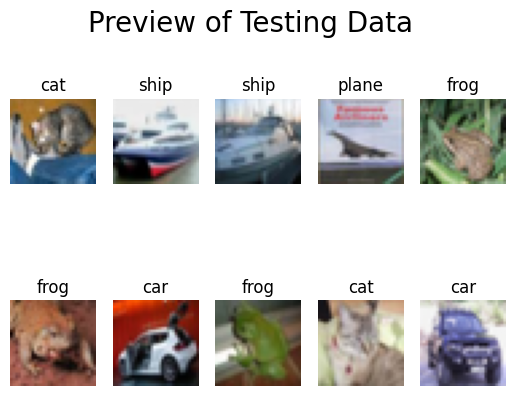

In [8]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Testing Data', size=20)
plt.show()

So we have successfully separated testing and training data and modified them accordingly.

**Updating the architecture: Removing dropout**

Now we remove the dropout layers: BN should perform the normalisation required and the dropout is possibly only harming the performance on such a small model.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # First defining layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)

        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flattening
        x = torch.flatten(x, 1)

        # Fully connected block 1
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Fully connected block 2
        x = self.fc2(x)
        x = self.bn4(x)
        x = F.relu(x)

        # Output layer
        x = self.fc3(x)

        return x

**Training the Neural Network**

**Prepare for Training**

Now we increase the SGD learning rate to (hopefully) increase performance despite only having limited training time. We increase it from 0.001 to 0.01

In [10]:
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


print("Your network is ready for training!")

Your network is ready for training!


The above sets up the model, a loss function and an optimiser, so that we can train the network. Here's a further breakdown:


```
net = Net()
```
net creates an 'instance' our our neural network model Net. This model is like a "blank slate", as it has a learning framework set up but hasn't yet actually learnt from data.


```
criterion = nn.CrossEntropyLoss()
```
The above is the loss function. We use CrossEntropyLoss which is best for classification problems. The idea behind this function is to measure the difference between the models predictions and actual labels.



```
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
```
This sets up the 'optimiser', which updates weights and biases to reduce loss at each training step. Here we use stochastic gradient descent (SGD), which takes small steps in the direction that reduces the loss.

The learning rate (lr=0.001) controls step size. A small learning rate ensures gradual improvements, while momentum (momentum = 0.9) helps smooth out the updates, making the training more stable and efficient.




**Training and saving the model**

Now we move into the traning phase - the model learns to classify images by iterating through the dataset multiple times (also called 'epochs')

In [11]:
from tqdm import tqdm

EPOCHS = 5
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 5 of 5: 100%|█████████████████████████| 5000/5000 [00:54<00:00, 92.37it/s]


Let's break this down. First, we set the number of epochs to 2. Then we create a 'for' loop for each epoch:

We start by resetting running_loss to zero. This variable tracks the cumulative loss during each epoch, giving us an idea of how well the model is learning over time. NOTE TO SELF: this could be useful when deciding on a computational expense/overfitting vs accuracy optimisation - set epochs to the time when running loss starts to taper off quickly.

The inner loop processes each batch of images from the training set. The tqdm library gives a progress bar for each epoch, to monitor training progress (NOTE: and maybe track where it slows down?)

The next part is: **Forward Pass and Backpropagation**.



```
optimizer.zero_grad()
outputs = net(inputs)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()
```

First, optimizer.zero_grad() resets previous gradient values (otherwise pytorch includes prevous values).

outputs = net(inputs): the model makes predictions for the current batch, passing inputs through the network.

loss = criterion(outputs,labels): the loss function is calculated

loss.backward(): backpropagation calculates gradients of loss with respect to each parameter to inform how to change the model.

optimizer.step(): updates parameters accordingly, by one step





Then after training we save the model's state to a file. This can be reloaded later for testing or further training without having to wait for the model to retrain.

**Testing the model**

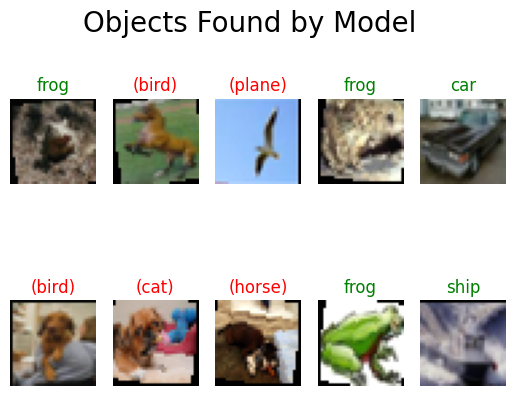

In [13]:
# Pick random photos from training set
if traindataiter == None:
    traindataiter = iter(trainloader)
images, labels = next(traindataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

**Evaluating model accuracy**

In [14]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    accuracies.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

average_accuracy = sum(accuracies) / len(accuracies)
print(f'\nAverage accuracy over all classes: {average_accuracy:.1f} %') #we  add some code to measure overall accuracy as our baseline performance metric

Accuracy for class: plane is 53.2 %
Accuracy for class: car   is 68.8 %
Accuracy for class: bird  is 52.6 %
Accuracy for class: cat   is 33.1 %
Accuracy for class: deer  is 47.4 %
Accuracy for class: dog   is 41.9 %
Accuracy for class: frog  is 72.1 %
Accuracy for class: horse is 67.3 %
Accuracy for class: ship  is 74.6 %
Accuracy for class: truck is 74.8 %

Average accuracy over all classes: 58.6 %


The accuracy has jumped up again, so our changes helped. On the assumption that increased learning rate was one of the improvements, let's try changing the optimiser in the next draft.